In [ ]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [ ]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

In [ ]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/ETH.csv')

In [ ]:
# Список финансовых инструментов в портфеле
TIKERS = ['ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [ ]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

In [72]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 1454 (major_axis) x 2 (minor_axis)
Items axis: ETH to ETH
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-23 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [73]:
data_corr = data['ETH']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,ETH
ETH,1.0


# Построение границы эффективности

###  Задаем стартовые параметры

In [74]:
# set the number of combinations for imaginary portfolios
num_portfolios = 1
COMMISSION = 0.0007
REBALANCE_PERIOD = 63
DELTA = 0.5

### Определяем стартовые переменные

In [75]:
num_assets = len(TIKERS)

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [76]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in tqdm(range(num_portfolios)):
    WEIGHTS = [1]
    
    def initialize(context):
    
        context.set_commission(commission.PerDollar(cost=COMMISSION))

        set_benchmark(symbol('ETH'))

        context.tikers = TIKERS
        context.assets = [context.symbol(symbol) for symbol in context.tikers]

        context.weights = WEIGHTS
        context.n_assets = len(context.assets)

        context.window = 1

        context.rebalance_count = 0
        context.time = 0
        
    
    def handle_data(context, data):
    
        if context.time == 0:

            # extract prices
            prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

            # submit orders
            for i, asset in enumerate(context.assets):
                order_target_percent(asset, context.weights[i])

            context.time += 1
    
        else:
            for i, asset in enumerate(context.assets):
                if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i])/context.weights[i] > DELTA:
                    order_target_percent(asset, context.weights[i])
                    context.rebalance_count += 1

            context.time += 1
    
    perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                                  end=datetime(2019, 12, 20, 0, 0, 0, 0, pytz.utc),
                                  initialize=initialize,
                                  capital_base=100000000,
                                  handle_data=handle_data,
                                  trading_calendar=AlwaysOpenCalendar(),
                                  data=panel)

    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
    port_returns.append(qf.get_performance_summary(returns).annualized_returns)
    port_volatility.append(qf.get_performance_summary(returns).annual_volatility)
    stock_weights.append(WEIGHTS)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.39s/it]


# Визуализация результатов

In [77]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [78]:
df.head()

,Returns,Volatility,Sharpe Ratio,ETH Weight
0,1.353802,0.979105,1.352873,1


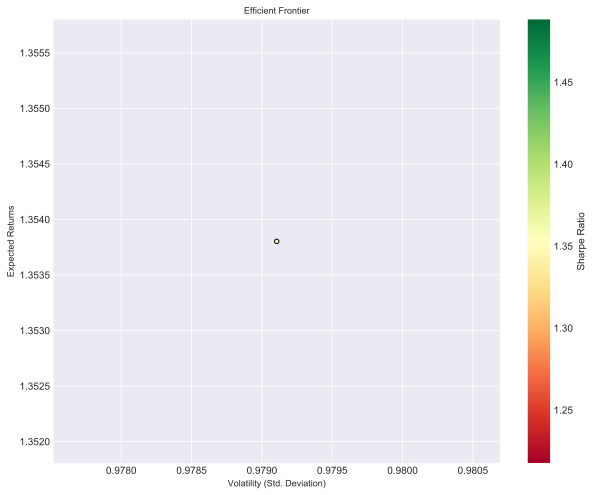

In [15]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
#fig, ax = plt.subplots()
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

# Оптимальное соотношение активов

In [34]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_returns = df['Returns'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_return_portfolio = df.loc[df['Returns'] == max_returns]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='o', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='o', s=200 )
plt.scatter(x=max_return_portfolio['Volatility'], y=max_return_portfolio['Returns'], c='red', marker='o', s=200 )

plt.annotate('Max sharpe', xy=(sharpe_portfolio['Volatility'], sharpe_portfolio['Returns']), xytext=(0.2, 1.1), 
             arrowprops=dict(facecolor='black', shrink=0.01))

plt.xlabel('Standard deviation')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

ValueError: Image size of 168893x145278 pixels is too large. It must be less than 2^16 in each direction.

In [35]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)
print(max_return_portfolio.T)

                     0
Returns       0.631567
Volatility    0.629939
Sharpe Ratio  1.091120
BTC Weight    1.000000
                     0
Returns       0.631567
Volatility    0.629939
Sharpe Ratio  1.091120
BTC Weight    1.000000
                     0
Returns       0.631567
Volatility    0.629939
Sharpe Ratio  1.091120
BTC Weight    1.000000
